In [99]:
import pickle
import os
import torch

import numpy as np
import geopandas as gpd
import jax
import jax.numpy as jnp
from jax import random
from jax import random, lax, jit, ops
from jax.example_libraries import stax

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import dill

import time

In [100]:
#define the necessary functions
def dist_euclid(x, z):
    """
    Computes Eucledian Distance Between Regions. This function is used by
    exp_sq_kernel function (kernel function for gaussian processes)
    """
    x = jnp.array(x) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    z = jnp.array(z) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    n_x, m = x.shape # 7304 , 2
    n_z, m_z = z.shape # 7304 , 2
    assert m == m_z
    delta = jnp.zeros((n_x,n_z)) #(ngrid_pts,ngrid_pts) <- i.e (7304,7304)
    for d in jnp.arange(m):
        x_d = x[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        z_d = z[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        delta += (x_d[:,jnp.newaxis] - z_d)**2 # (7304,7304)

    return jnp.sqrt(delta) #(7304,7304)
def exp_sq_kernel(x, z, var, length, noise, jitter=1.0e-4):
    dist = dist_euclid(x, z) #(7304, 7304)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k # (ngrid_pts, ngrid_pts) <- (7304,7304)

def vae_decoder(hidden_dim, out_dim):
    return stax.serial(
        # (num_samples, z_dim) -> (num_samples, hidden_dim): (5,40) -> (5,50)
        stax.Dense(hidden_dim, W_init = stax.randn()),
        stax.Elu,
        # (num_samples, hidden_dim) -> (num_samples, num_regions) : (5,50) -> (5, 58)
        stax.Dense(out_dim, W_init = stax.randn())
    )

In [ ]:
def prev_model_vae_aggr(args):

    x = args["x"]
    out_dims = args["out_dims"]
    n = args["sigma"]

    #covariates
    pop_density_lo = args["pop_density_lo"]  # (4,) one province (jkt) for 4 yrs' data
    pop_density_hi = args["pop_density_hi"]  # (24,)
    hdi_lo = args["hdi_lo"]  # (4,) 6 districts within jkt for 4 yrs' data
    hdi_hi = args["hdi_hi"]  # (24,)
    urban_lo = args["urban_lo"]  # (4,) 6 districts within jkt for 4 yrs' data
    urban_hi = args["urban_hi"]  # (24,)
    total_population_lo = args["total_population_lo"]
    total_population_hi = args["total_population_hi"]

    n_hi_regions = total_population_hi.shape[0] #24

    #aggregate pop_density tgt
    pop_density = jnp.concatenate([pop_density_lo,pop_density_hi], axis = 0)

    #aggregate hdi tgt
    hdi = jnp.concatenate([hdi_lo,hdi_hi], axis = 0)

    #aggregate urbanicity tgt
    urban = jnp.concatenate([urban_lo,urban_hi], axis = 0)

    #aggregate total populations low and high
    total_population = jnp.concatenate([total_population_lo,total_population_hi], axis = 0)

    total_cases_lo = args["total_cases_lo"] #cos we wanna predict total cases district-wise, so only feed total cases for low res data

    # random effect
    decoder_params =args["decoder_params"]
    z_dim, hidden_dim = decoder_params[0][0].shape
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    _, decoder_apply = vae_decoder(hidden_dim, out_dims) #Instantiate decoder
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_apply(decoder_params, z))
    s = numpyro.sample("sigma", dist.HalfNormal(n))
    vae = numpyro.deterministic("vae", s * vae_aggr)

    ## Fixed effects
    b0 = numpyro.sample("b0", dist.Normal(0, 1))  #Intercept
    b_pop_density = numpyro.sample("b_pop_density", dist.Normal(0, 1))  #Effect of population density
    b_hdi = numpyro.sample("b_hdi", dist.Normal(0, 1))  #Effect of HDI
    b_urban = numpyro.sample("b_urban", dist.Normal(0, 1))  # Effect of urbanicity

    # Linear predictor
    lp = b0 + vae + b_pop_density * pop_density + b_hdi * hdi + b_urban * urban # (num_districts,)

    # Prevalence probability
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp)*1e-2)  # (num_districts,)

    #add NaN values to total_cases to accommodate for unavailable total cases data for high resolution (that we want to predict)
    total_cases = jnp.pad(total_cases_lo, (0, n_hi_regions),constant_values = 0.0) #[3762.  484. ... , 0,0,0]
    total_cases = jnp.where(total_cases == 0, jnp.nan, total_cases)# [3762.  484. ... , nan,nan,nan]
    total_cases_mask = ~jnp.isnan(total_cases) # [True, True, ...., False, False, False]

    # Binomial likelihood
    with numpyro.handlers.mask(mask=total_cases_mask):
        observed_cases = numpyro.sample(
            "observed_cases",
            dist.Binomial(total_count=total_population, probs=theta),
            obs=total_cases)

    return observed_cases



## Load variables

In [102]:
# Lat/Lon Values of artificial grid
x = np.load("../data/lat_lon_x_jkt.npy")
df_lo = gpd.read_file('../data/jkt_prov.shp')
df_hi = gpd.read_file('../data/jkt_dist.shp')

In [103]:
#hidden dim of vae
h = 30

#z dim of vae
a = 40

##Arguments to Model

In [ ]:
args = {
        "pop_density_lo": jnp.array(df_lo["Pop_den"]), # Shape (num_districts,)
        "pop_density_hi": jnp.array(df_hi["Pop_den"]), # Shape (num_districts,)
        "hdi_lo": jnp.array(df_lo["HDI"]), # Shape (num_districts, 2)
        "hdi_hi": jnp.array(df_hi["HDI"]), # Shape (num_districts, 2)
        "total_cases_lo" : jnp.array(df_lo["Cases"]),
        "urban_lo" = jnp.array(df_lo["urban_qt"]),
        "urban_hi" = jnp.array(df_hi["urban_qt"]),
        "total_population_lo" : jnp.array(df_lo["Population"]),
        "total_population_hi" : jnp.array(df_hi["Population"]),
        "x" : jnp.array(x),
        "gp_kernel" : exp_sq_kernel,
        "jitter" : 1e-4,
        "noise" : 1e-4,
        # VAE training
        "rng_key": random.PRNGKey(5),
        "num_epochs": 20,
        "learning_rate": 0.0005,
        "batch_size": 100,
        "out_dims" : df_lo.shape[0] + df_hi.shape[0], #28
        "num_train": 100,
        "num_test":100,
        "vae_var": 1,
        "sigma": 30
    }

##Load decoder model

In [105]:
#change the specific file name under the folder model_weights
with open("../model weights/aggVAE/aggVAE_e20_h30_z40", "rb") as file:
        vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]
args["decoder_params"] = decoder_params

##Run MCMC

In [106]:
# Get script location and define correct save directory (sibling to src/)
script_dir = os.getcwd()  # Get current working directory
save_dir = os.path.abspath(os.path.join(script_dir, "..", "model weights", "aggVAEPrev"))  # Move up and into model_weights
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

#set seed for running mcmc
mcmc_key, predict_key = random.split(random.PRNGKey(0))
start_time = time.time()
mcmc = MCMC(NUTS(prev_model_vae_aggr), num_warmup = 1000, num_samples = 2000, num_chains = 4)

mcmc.run(mcmc_key, args)
t_elapsed = time.time() - start_time
t_elapsed_mins = int(t_elapsed / 60)

mcmc.print_summary(exclude_deterministic = False)

C:\Users\jessi\AppData\Local\Temp\ipykernel_8976\416112565.py:9: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(prev_model_vae_aggr), num_warmup = 1000, num_samples = 2000, num_chains = 4)
sample: 100%|██████████| 3000/3000 [00:10<00:00, 284.14it/s, 511 steps of size 1.20e-02. acc. prob=0.93]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0      0.74      0.78      0.78     -0.48      2.08   5946.55      1.00
          b_hdi      1.03      0.26      1.02      0.58      1.45   6109.28      1.00
  b_pop_density      0.37      0.96      0.38     -1.23      1.95   9867.80      1.00
          sigma    136.39     16.82    135.87    108.75    163.65   8250.99      1.00
       theta[0]      0.00      0.00      0.00      0.00      0.00   9152.34      1.00
       theta[1]      0.00      0.00      0.00      0.00      0.00   9034.77      1.00
       theta[2]      0.00      0.00      0.00      0.00      0.00   8032.46      1.00
       theta[3]      0.00      0.00      0.00      0.00      0.00   8870.77      1.00
       theta[4]      0.00      0.00      0.00      0.00      0.01   6821.50      1.00
       theta[5]      0.00      0.00      0.00      0.00      0.01   6895.32      1.00
       theta[6]      0.00      0.00      0.00      0.

In [107]:
n_samples = 2000
n_warmup = 1000
n = args["sigma"]

#save the mcmc
f_path = os.path.join(save_dir, f"aggVAEPrev_nsamples_{n_samples}_tt{t_elapsed_mins}min_sigma{n}_hdim{h}_zdim{a}.pkl")
with open(f_path, "wb") as file:
    dill.dump(mcmc, file)

print(f"Saved aggVAEPrev MCMC samples to {f_path}")

Saved aggVAEPrev MCMC samples to c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\DSE_FYP\simulation study\model weights\aggVAEPrev\aggVAEPrev_nsamples_2000_tt0min_sigma30_hdim30_zdim40.pkl


In [108]:
#print total elapsed time
total_end = time.time()
print("\nMCMC Total elapsed time:", round(total_end), "s")
print("MCMC Total elapsed time:", round(total_end / 60), "min")
print("MCMC Total elapsed time:", round(total_end / (60 * 60)), "h")


MCMC Total elapsed time: 1743725989 s
MCMC Total elapsed time: 29062100 min
MCMC Total elapsed time: 484368 h


In [109]:
#print the summary stats
samples = mcmc.get_samples(group_by_chain = True)
mcmc.print_summary(exclude_deterministic=False)


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0      0.74      0.78      0.78     -0.48      2.08   5946.55      1.00
          b_hdi      1.03      0.26      1.02      0.58      1.45   6109.28      1.00
  b_pop_density      0.37      0.96      0.38     -1.23      1.95   9867.80      1.00
          sigma    136.39     16.82    135.87    108.75    163.65   8250.99      1.00
       theta[0]      0.00      0.00      0.00      0.00      0.00   9152.34      1.00
       theta[1]      0.00      0.00      0.00      0.00      0.00   9034.77      1.00
       theta[2]      0.00      0.00      0.00      0.00      0.00   8032.46      1.00
       theta[3]      0.00      0.00      0.00      0.00      0.00   8870.77      1.00
       theta[4]      0.00      0.00      0.00      0.00      0.01   6821.50      1.00
       theta[5]      0.00      0.00      0.00      0.00      0.01   6895.32      1.00
       theta[6]      0.00      0.00      0.00      0.

In [110]:
#metric values (ESS and Rhat)
n_lo = df_lo.shape[0]
n_hi = df_hi.shape[0]

ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain = True))
r = np.mean(ss["vae_aggr"]["n_eff"])

print(f"Average ESS for all aggVAE effects : {round(r)}")

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:n_lo])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:n_lo])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][n_lo:n_lo + n_hi])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][n_lo : n_lo + n_hi])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")


Average ESS for all aggVAE effects : 6743
Average ESS for all aggVAE-low effects : 5248
Max r_hat for all aggVAE-low : 1.0
Average ESS for all aggVAE-high effects : 6992
Max r_hat for all aggVAE-high : 1.0


## Append Predictions

In [111]:
samples["theta"].shape

(4, 2000, 28)

In [112]:
theta_mean_gp = samples["theta"].mean(axis = (0,1))
bci_gp_25 = np.quantile(samples["theta"],0.25,axis = (0,1))
bci_gp_75 = np.quantile(samples["theta"],0.75, axis = (0,1))

df_lo["obs_prev"] = df_lo["Cases"] / df_lo["Population"]
df_hi["obs_prev"] = df_hi["Cases"] / df_hi["Population"]

df_lo["theta_vae"] = theta_mean_gp[0:n_lo]
df_hi["theta_vae"] = theta_mean_gp[n_lo:n_lo + n_hi]

theta_obs_lo = df_lo["obs_prev"]
theta_vae_est_lo = df_lo["theta_vae"]
theta_obs_hi = df_hi["obs_prev"]
theta_vae_est_hi = df_hi["theta_vae"]

max_val_lo = np.max([theta_obs_lo, theta_vae_est_lo])
min_val_lo = np.min([theta_obs_lo, theta_vae_est_lo])

max_val_hi = np.max([theta_obs_hi, theta_vae_est_hi])
min_val_hi = np.min([theta_obs_hi, theta_vae_est_hi])

## Plot

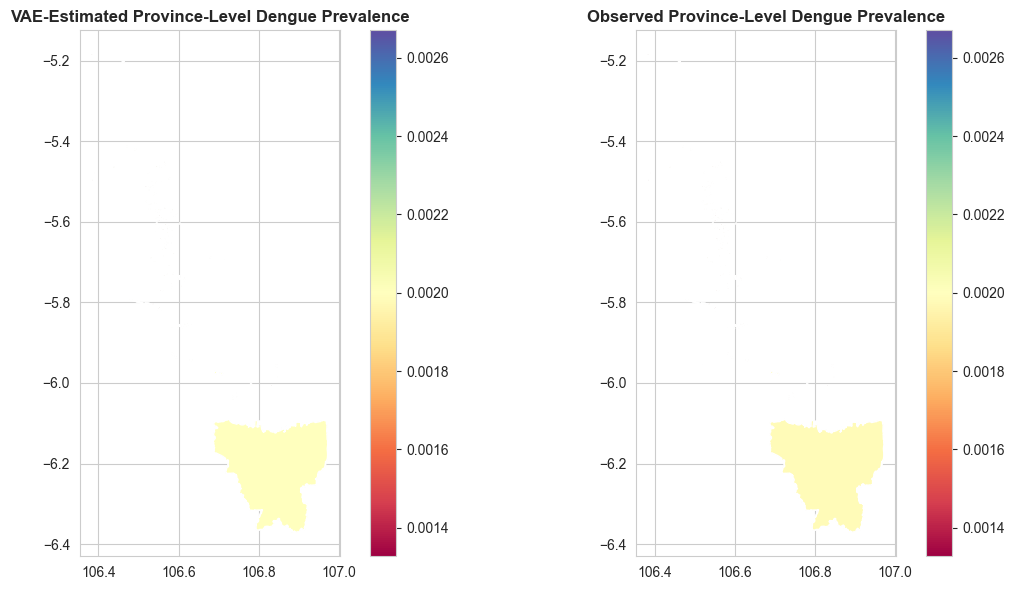

Plot saved to ../plots/prov_vae_vs_observed_prevalence_sigma30_vae_hiddendim_30_zdim_40.png


In [113]:
#plot the observed prevalence vs vae-estimated prevalence (low-res)
# Set Seaborn style for better visualization
sns.set_style("whitegrid")

# Define a more contrasting color scheme (Spectral has strong contrast)
cmap_choice = "Spectral"  # Try 'coolwarm', 'viridis', 'RdYlBu', or 'Spectral' for better distinction

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot using a high-contrast colormap
df_lo.plot(column="theta_vae", ax=ax[0], legend=True, cmap=cmap_choice, vmin=min_val_lo, vmax=max_val_lo)
df_lo.plot(column="obs_prev", ax=ax[1], legend=True, cmap=cmap_choice, vmin=min_val_lo, vmax=max_val_lo)

ax[0].set_title("VAE-Estimated Province-Level Dengue Prevalence", fontsize=12, fontweight="bold")
ax[1].set_title("Observed Province-Level Dengue Prevalence", fontsize=12, fontweight="bold")

# Improve spacing
plt.tight_layout()

# Save the plot
plot_dir = "../plots"  # Adjust based on directory structure
os.makedirs(plot_dir, exist_ok=True)

# Define the filename
filename = f"{plot_dir}/prov_vae_vs_observed_prevalence_sigma{n}_vae_hiddendim_{h}_zdim_{a}.png"

plt.savefig(filename, dpi=300, bbox_inches="tight")  # Save with high resolution

# Show the plot (optional)
plt.show()

print(f"Plot saved to {filename}")

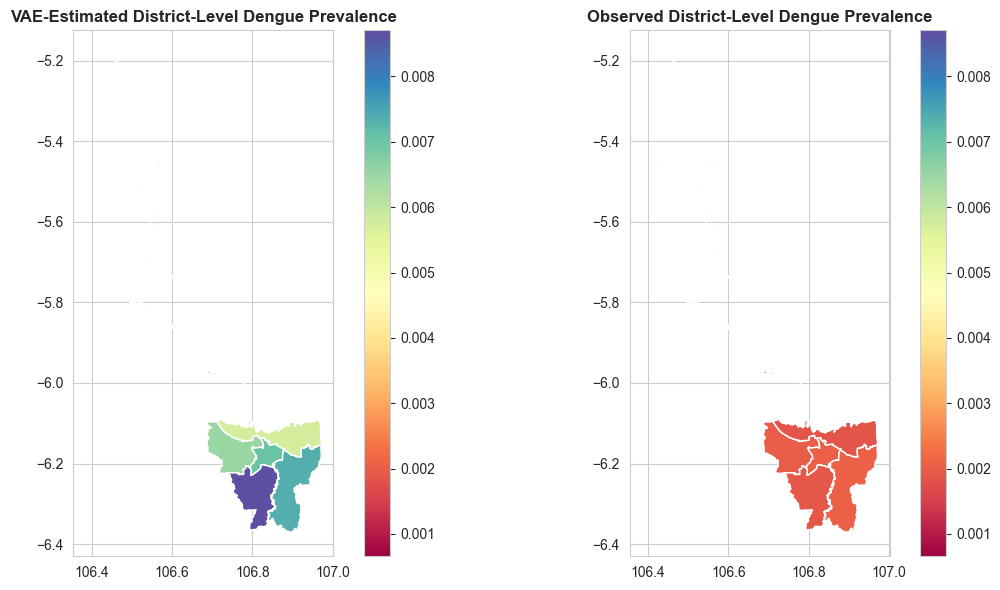

Plot saved to ../plots/dist_vae_vs_observed_prevalence_sigma30_vae_hiddendim_30_zdim_40.png


In [114]:
#plot observed vs estimated prevalence (high-res)
#plot the observed prevalence vs vae-estimated prevalence (low-res)
# Set Seaborn style for better visualization
sns.set_style("whitegrid")

# Define a more contrasting color scheme (Spectral has strong contrast)
cmap_choice = "Spectral"  # Try 'coolwarm', 'viridis', 'RdYlBu', or 'Spectral' for better distinction

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot using a high-contrast colormap
df_hi.plot(column="theta_vae", ax=ax[0], legend=True, cmap=cmap_choice, vmin=min_val_hi, vmax=max_val_hi)
df_hi.plot(column="obs_prev", ax=ax[1], legend=True, cmap=cmap_choice, vmin=min_val_hi, vmax=max_val_hi)

ax[0].set_title("VAE-Estimated District-Level Dengue Prevalence", fontsize=12, fontweight="bold")
ax[1].set_title("Observed District-Level Dengue Prevalence", fontsize=12, fontweight="bold")

# Improve spacing
plt.tight_layout()

# Save the plot
plot_dir = "../plots"  # Adjust based on directory structure
os.makedirs(plot_dir, exist_ok=True)

# Define the filename
filename = f"{plot_dir}/dist_vae_vs_observed_prevalence_sigma{n}_vae_hiddendim_{h}_zdim_{a}.png"

plt.savefig(filename, dpi=300, bbox_inches="tight")  # Save with high resolution

# Show the plot (optional)
plt.show()

print(f"Plot saved to {filename}")

## Save files with aggVAE Prev predictions

In [115]:
df_lo.to_csv('../data/df_with_aggVAE_preds_lo.csv')
df_lo.to_file('../data/df_with_aggVAE_preds_lo.shp')
df_hi.to_csv('../data/df_with_aggVAE_preds_hi.csv')
df_hi.to_file('../data/df_with_aggVAE_preds_hi.shp')